# Numba Performance Benchmark

This notebook compares the performance of different gravity calculation methods:
1. **Direct Summation (Pure Python/NumPy)**: O(N²) baseline
2. **Direct Summation (Numba)**: O(N²) but JIT-compiled and parallelized
3. **Tree (Barnes-Hut)**: O(N log N) algorithm

We'll test accuracy and performance scaling across different particle counts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import gravhydro as gh
from gravhydro import Simulation
from gravhydro.gravity.numba_gravity import (
    NumbaGravity, 
    is_numba_available,
    direct_force_summation_numba,
    direct_force_summation_numba_serial,
    NUMBA_AVAILABLE
)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

print(f"Numba available: {NUMBA_AVAILABLE}")

Numba available: True


## 1. Verify Numba Installation and Warmup JIT

In [2]:
if NUMBA_AVAILABLE:
    print("Warming up JIT compilation...")
    
    # Small warmup to compile the functions
    test_pos = np.random.randn(50, 3).astype(np.float64)
    test_mass = np.ones(50, dtype=np.float64)
    
    # Compile serial version
    start = time.time()
    _ = direct_force_summation_numba_serial(test_pos, test_mass)
    print(f"Serial JIT compile time: {time.time() - start:.3f}s")
    
    # Compile parallel version
    start = time.time()
    _ = direct_force_summation_numba(test_pos, test_mass)
    print(f"Parallel JIT compile time: {time.time() - start:.3f}s")
    
    print("\nJIT compilation complete!")
else:
    print("Numba is not installed. Install with: pip install numba")

Warming up JIT compilation...
Serial JIT compile time: 0.500s
Parallel JIT compile time: 0.397s

JIT compilation complete!


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## 2. Accuracy Comparison

First, let's verify that the Numba implementation produces the same results as the original.

In [3]:
# Generate test data
np.random.seed(42)
n_test = 100
positions = np.random.randn(n_test, 3).astype(np.float64)
masses = np.random.uniform(0.5, 2.0, n_test).astype(np.float64)

# Compute forces with different methods
sim = Simulation(use_numba=False)

# Pure Python/NumPy
forces_numpy = sim.directForceSummation(positions, masses)

if NUMBA_AVAILABLE:
    # Numba serial
    forces_numba_serial = direct_force_summation_numba_serial(positions, masses)
    
    # Numba parallel
    forces_numba_parallel = direct_force_summation_numba(positions, masses)
    
    # Compare
    diff_serial = np.abs(forces_numpy - forces_numba_serial)
    diff_parallel = np.abs(forces_numpy - forces_numba_parallel)
    
    print("Accuracy Comparison (vs NumPy baseline):")
    print("="*50)
    print(f"Numba Serial   - Max diff: {np.max(diff_serial):.2e}, Mean diff: {np.mean(diff_serial):.2e}")
    print(f"Numba Parallel - Max diff: {np.max(diff_parallel):.2e}, Mean diff: {np.mean(diff_parallel):.2e}")
    print("\n✓ Results match within numerical precision!" if np.allclose(forces_numpy, forces_numba_serial) else "✗ Results differ!")
else:
    print("Numba not available - skipping comparison")

Accuracy Comparison (vs NumPy baseline):
Numba Serial   - Max diff: 9.00e-07, Mean diff: 3.02e-08
Numba Parallel - Max diff: 9.00e-07, Mean diff: 3.02e-08

✓ Results match within numerical precision!


## 3. Performance Benchmarks

### 3.1 Direct Force Calculation Only

Let's benchmark just the force calculation step (no integration).

In [4]:
def benchmark_force_calculation(particle_counts, num_trials=5):
    """
    Benchmark force calculation methods.
    """
    results = {
        'n_particles': [],
        'numpy_times': [],
        'numpy_std': [],
        'numba_serial_times': [],
        'numba_serial_std': [],
        'numba_parallel_times': [],
        'numba_parallel_std': [],
    }
    
    sim = Simulation(use_numba=False)
    
    for n in particle_counts:
        print(f"Testing N = {n}...")
        
        numpy_times = []
        numba_serial_times = []
        numba_parallel_times = []
        
        for trial in range(num_trials):
            np.random.seed(42 + trial)
            pos = np.random.randn(n, 3).astype(np.float64)
            mass = np.ones(n, dtype=np.float64)
            
            # NumPy
            start = time.time()
            _ = sim.directForceSummation(pos, mass)
            numpy_times.append(time.time() - start)
            
            if NUMBA_AVAILABLE:
                # Numba serial
                start = time.time()
                _ = direct_force_summation_numba_serial(pos, mass)
                numba_serial_times.append(time.time() - start)
                
                # Numba parallel
                start = time.time()
                _ = direct_force_summation_numba(pos, mass)
                numba_parallel_times.append(time.time() - start)
        
        results['n_particles'].append(n)
        results['numpy_times'].append(np.mean(numpy_times))
        results['numpy_std'].append(np.std(numpy_times))
        
        if NUMBA_AVAILABLE:
            results['numba_serial_times'].append(np.mean(numba_serial_times))
            results['numba_serial_std'].append(np.std(numba_serial_times))
            results['numba_parallel_times'].append(np.mean(numba_parallel_times))
            results['numba_parallel_std'].append(np.std(numba_parallel_times))
    
    return results

# Run benchmarks
particle_counts = [50, 100, 200, 500, 1000, 2000]
print("Benchmarking force calculations...\n")
force_results = benchmark_force_calculation(particle_counts)

Benchmarking force calculations...

Testing N = 50...
Testing N = 100...
Testing N = 200...
Testing N = 500...
Testing N = 1000...
Testing N = 2000...


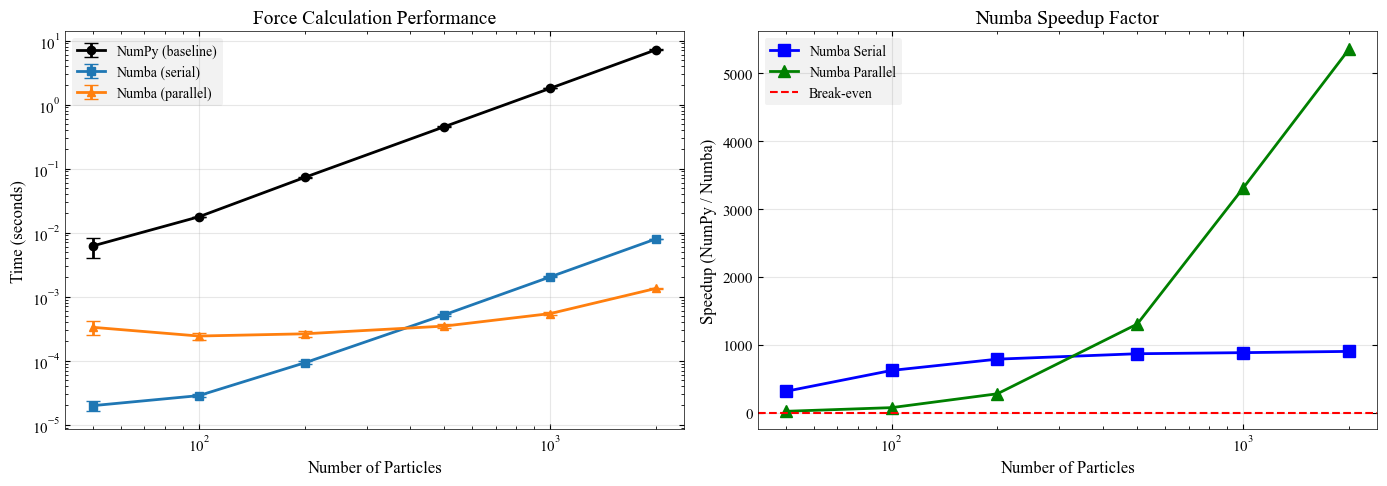


Force Calculation Benchmark Summary:
N        NumPy (ms)      Numba Ser (ms)     Numba Par (ms)     Speedup (par)
--------------------------------------------------------------------------------
50       6.20            0.02               0.33               18.7        x
100      17.63           0.03               0.24               72.9        x
200      72.66           0.09               0.26               277.2       x
500      451.37          0.52               0.35               1304.9      x
1000     1794.32         2.03               0.54               3306.6      x
2000     7183.57         7.97               1.34               5352.3      x


In [5]:
# Plot force calculation benchmarks
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n = np.array(force_results['n_particles'])
numpy_t = np.array(force_results['numpy_times'])

# Plot 1: Absolute times
ax1 = axes[0]
ax1.errorbar(n, numpy_t, yerr=force_results['numpy_std'], 
             marker='o', label='NumPy (baseline)', capsize=5, linewidth=2)

if NUMBA_AVAILABLE and len(force_results['numba_serial_times']) > 0:
    numba_serial_t = np.array(force_results['numba_serial_times'])
    numba_parallel_t = np.array(force_results['numba_parallel_times'])
    
    ax1.errorbar(n, numba_serial_t, yerr=force_results['numba_serial_std'], 
                 marker='s', label='Numba (serial)', capsize=5, linewidth=2)
    ax1.errorbar(n, numba_parallel_t, yerr=force_results['numba_parallel_std'], 
                 marker='^', label='Numba (parallel)', capsize=5, linewidth=2)

ax1.set_xlabel('Number of Particles', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Force Calculation Performance', fontsize=14)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Speedup
ax2 = axes[1]
if NUMBA_AVAILABLE and len(force_results['numba_serial_times']) > 0:
    speedup_serial = numpy_t / numba_serial_t
    speedup_parallel = numpy_t / numba_parallel_t
    
    ax2.plot(n, speedup_serial, 'b-s', linewidth=2, markersize=8, label='Numba Serial')
    ax2.plot(n, speedup_parallel, 'g-^', linewidth=2, markersize=8, label='Numba Parallel')
    ax2.axhline(y=1, color='r', linestyle='--', label='Break-even')
    
ax2.set_xlabel('Number of Particles', fontsize=12)
ax2.set_ylabel('Speedup (NumPy / Numba)', fontsize=12)
ax2.set_title('Numba Speedup Factor', fontsize=14)
ax2.set_xscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nForce Calculation Benchmark Summary:")
print("="*80)
if NUMBA_AVAILABLE and len(force_results['numba_serial_times']) > 0:
    print(f"{'N':<8} {'NumPy (ms)':<15} {'Numba Ser (ms)':<18} {'Numba Par (ms)':<18} {'Speedup (par)':<12}")
    print("-"*80)
    for i, n_val in enumerate(n):
        print(f"{n_val:<8} {numpy_t[i]*1000:<15.2f} {numba_serial_t[i]*1000:<18.2f} {numba_parallel_t[i]*1000:<18.2f} {speedup_parallel[i]:<12.1f}x")
else:
    print("Numba not available")

### 3.2 Full Simulation Benchmark

Now let's benchmark the full simulation including integration.

In [6]:
def benchmark_simulation(particle_counts, n_steps=10, num_trials=3):
    """
    Benchmark full simulation with different methods.
    """
    results = {
        'n_particles': [],
        'direct_numpy': [],
        'direct_numpy_std': [],
        'direct_numba': [],
        'direct_numba_std': [],
        'tree': [],
        'tree_std': [],
    }
    
    dt = 0.01
    ts = np.linspace(0, dt * n_steps, n_steps + 1)
    
    for n in particle_counts:
        print(f"Testing N = {n}...")
        
        direct_numpy_times = []
        direct_numba_times = []
        tree_times = []
        
        for trial in range(num_trials):
            np.random.seed(42 + trial)
            pos = np.random.randn(n, 3).astype(np.float64)
            mom = np.zeros_like(pos)
            mass = np.ones(n, dtype=np.float64)
            
            # Direct summation (NumPy)
            sim_numpy = Simulation(use_numba=False)
            start = time.time()
            _ = sim_numpy.run(pos.copy(), mom.copy(), mass, ts, gravityMethod='directSummation', use_numba=False)
            direct_numpy_times.append(time.time() - start)
            
            if NUMBA_AVAILABLE:
                # Direct summation (Numba)
                sim_numba = Simulation(use_numba=True)
                start = time.time()
                _ = sim_numba.run(pos.copy(), mom.copy(), mass, ts, gravityMethod='directSummation', use_numba=True)
                direct_numba_times.append(time.time() - start)
            
            # Tree method
            sim_tree = Simulation(use_numba=False)
            start = time.time()
            _ = sim_tree.run(pos.copy(), mom.copy(), mass, ts, gravityMethod='tree', threshold=0.5)
            tree_times.append(time.time() - start)
        
        results['n_particles'].append(n)
        results['direct_numpy'].append(np.mean(direct_numpy_times))
        results['direct_numpy_std'].append(np.std(direct_numpy_times))
        results['tree'].append(np.mean(tree_times))
        results['tree_std'].append(np.std(tree_times))
        
        if NUMBA_AVAILABLE:
            results['direct_numba'].append(np.mean(direct_numba_times))
            results['direct_numba_std'].append(np.std(direct_numba_times))
    
    return results

# Run simulation benchmarks
sim_particle_counts = [50, 100, 200, 500, 1000]
print("Benchmarking full simulations (10 timesteps each)...\n")
sim_results = benchmark_simulation(sim_particle_counts, n_steps=10)

Benchmarking full simulations (10 timesteps each)...

Testing N = 50...
Testing N = 100...
Testing N = 200...
Testing N = 500...
Testing N = 1000...


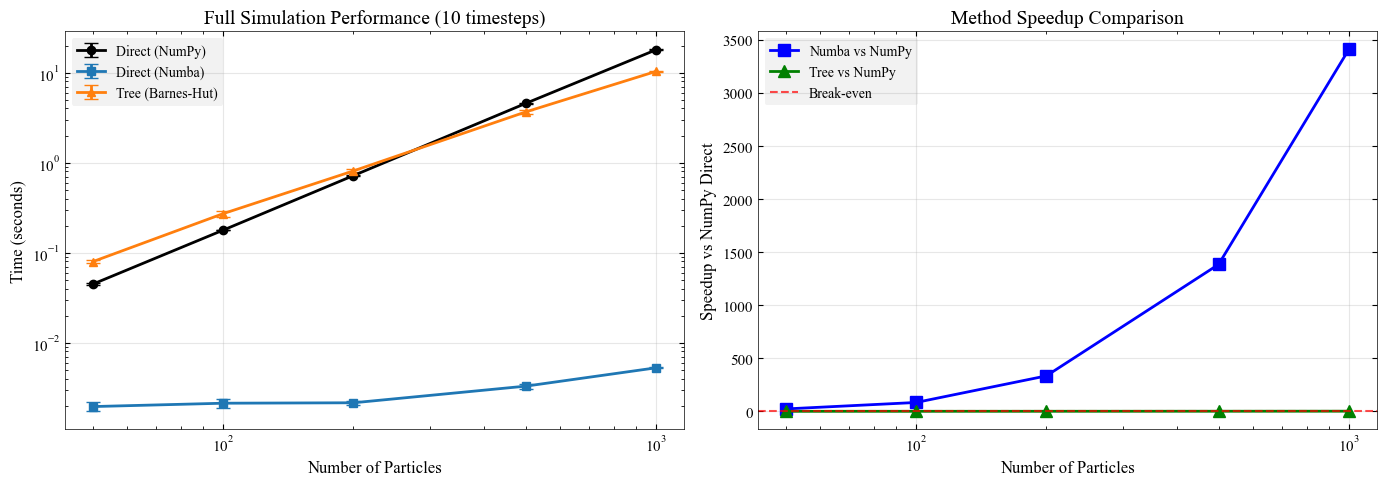


Simulation Benchmark Summary (10 timesteps):
N        Direct NumPy    Direct Numba    Tree            Numba Speedup   Tree Speedup
------------------------------------------------------------------------------------------
50       0.045s         0.002s         0.080s         22.9x          0.6x
100      0.178s         0.002s         0.272s         83.8x          0.7x
200      0.719s         0.002s         0.811s         334.2x          0.9x
500      4.559s         0.003s         3.665s         1384.4x          1.2x
1000     17.944s         0.005s         10.331s         3410.2x          1.7x


In [7]:
# Plot simulation benchmarks
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n = np.array(sim_results['n_particles'])
direct_numpy = np.array(sim_results['direct_numpy'])
tree = np.array(sim_results['tree'])

# Plot 1: Absolute times
ax1 = axes[0]
ax1.errorbar(n, direct_numpy, yerr=sim_results['direct_numpy_std'], 
             marker='o', label='Direct (NumPy)', capsize=5, linewidth=2)

if NUMBA_AVAILABLE and len(sim_results['direct_numba']) > 0:
    direct_numba = np.array(sim_results['direct_numba'])
    ax1.errorbar(n, direct_numba, yerr=sim_results['direct_numba_std'], 
                 marker='s', label='Direct (Numba)', capsize=5, linewidth=2)

ax1.errorbar(n, tree, yerr=sim_results['tree_std'], 
             marker='^', label='Tree (Barnes-Hut)', capsize=5, linewidth=2)

ax1.set_xlabel('Number of Particles', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Full Simulation Performance (10 timesteps)', fontsize=14)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Speedup relative to NumPy direct
ax2 = axes[1]
if NUMBA_AVAILABLE and len(sim_results['direct_numba']) > 0:
    speedup_numba = direct_numpy / direct_numba
    ax2.plot(n, speedup_numba, 'b-s', linewidth=2, markersize=8, label='Numba vs NumPy')

speedup_tree = direct_numpy / tree
ax2.plot(n, speedup_tree, 'g-^', linewidth=2, markersize=8, label='Tree vs NumPy')
ax2.axhline(y=1, color='r', linestyle='--', label='Break-even', alpha=0.7)

ax2.set_xlabel('Number of Particles', fontsize=12)
ax2.set_ylabel('Speedup vs NumPy Direct', fontsize=12)
ax2.set_title('Method Speedup Comparison', fontsize=14)
ax2.set_xscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table
print("\nSimulation Benchmark Summary (10 timesteps):")
print("="*90)
if NUMBA_AVAILABLE and len(sim_results['direct_numba']) > 0:
    print(f"{'N':<8} {'Direct NumPy':<15} {'Direct Numba':<15} {'Tree':<15} {'Numba Speedup':<15} {'Tree Speedup':<12}")
    print("-"*90)
    for i, n_val in enumerate(n):
        print(f"{n_val:<8} {direct_numpy[i]:.3f}s{'':<8} {direct_numba[i]:.3f}s{'':<8} {tree[i]:.3f}s{'':<8} {speedup_numba[i]:.1f}x{'':<9} {speedup_tree[i]:.1f}x")
else:
    print(f"{'N':<8} {'Direct NumPy':<15} {'Tree':<15} {'Tree Speedup':<12}")
    print("-"*50)
    for i, n_val in enumerate(n):
        print(f"{n_val:<8} {direct_numpy[i]:.3f}s{'':<8} {tree[i]:.3f}s{'':<8} {speedup_tree[i]:.1f}x")

## 4. Method Comparison: Accuracy vs Performance

Let's run a short simulation with all methods and compare the results.

In [8]:
# Set up a simple test case
np.random.seed(42)
n_particles = 100

# Random cluster of particles
positions = np.random.randn(n_particles, 3) * 0.5
momenta = np.zeros_like(positions)
masses = np.ones(n_particles) / n_particles

# Short simulation
dt = 0.01
t_end = 0.5
ts = np.linspace(0, t_end, int(t_end/dt) + 1)

print(f"Simulating {n_particles} particles for {len(ts)} timesteps...")

# Run with different methods
sim = Simulation()

# NumPy direct
start = time.time()
q_numpy, p_numpy = sim.run(positions.copy(), momenta.copy(), masses, ts, 
                            gravityMethod='directSummation', use_numba=False)
t_numpy = time.time() - start
print(f"Direct (NumPy): {t_numpy:.3f}s")

if NUMBA_AVAILABLE:
    # Numba direct
    start = time.time()
    q_numba, p_numba = sim.run(positions.copy(), momenta.copy(), masses, ts, 
                                gravityMethod='directSummation', use_numba=True)
    t_numba = time.time() - start
    print(f"Direct (Numba): {t_numba:.3f}s (speedup: {t_numpy/t_numba:.1f}x)")

# Tree
start = time.time()
q_tree, p_tree = sim.run(positions.copy(), momenta.copy(), masses, ts, 
                          gravityMethod='tree', threshold=0.5)
t_tree = time.time() - start
print(f"Tree (Barnes-Hut): {t_tree:.3f}s (speedup: {t_numpy/t_tree:.1f}x)")

Simulating 100 particles for 51 timesteps...
Direct (NumPy): 0.933s
Direct (Numba): 0.010s (speedup: 97.6x)
Tree (Barnes-Hut): 1.645s (speedup: 0.6x)


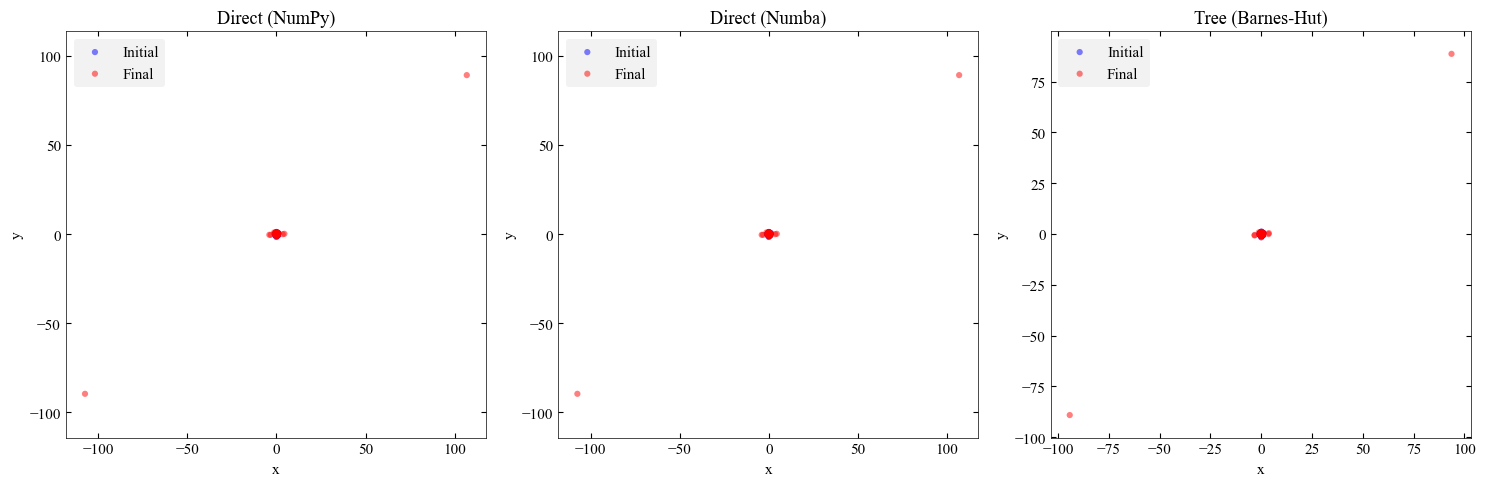


Position difference (NumPy vs Numba):
  Max: 1.05e-03, Mean: 2.17e-05

Position difference (NumPy vs Tree):
  Max: 1.34e+01, Mean: 2.99e-01


In [9]:
# Compare final positions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Initial vs Final (NumPy)
ax1 = axes[0]
ax1.scatter(positions[:, 0], positions[:, 1], c='blue', alpha=0.5, label='Initial', s=20)
ax1.scatter(q_numpy[-1, :, 0], q_numpy[-1, :, 1], c='red', alpha=0.5, label='Final', s=20)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Direct (NumPy)')
ax1.legend()
ax1.axis('equal')

if NUMBA_AVAILABLE:
    # Initial vs Final (Numba)
    ax2 = axes[1]
    ax2.scatter(positions[:, 0], positions[:, 1], c='blue', alpha=0.5, label='Initial', s=20)
    ax2.scatter(q_numba[-1, :, 0], q_numba[-1, :, 1], c='red', alpha=0.5, label='Final', s=20)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Direct (Numba)')
    ax2.legend()
    ax2.axis('equal')

# Initial vs Final (Tree)
ax3 = axes[2]
ax3.scatter(positions[:, 0], positions[:, 1], c='blue', alpha=0.5, label='Initial', s=20)
ax3.scatter(q_tree[-1, :, 0], q_tree[-1, :, 1], c='red', alpha=0.5, label='Final', s=20)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Tree (Barnes-Hut)')
ax3.legend()
ax3.axis('equal')

plt.tight_layout()
plt.show()

# Quantify differences
if NUMBA_AVAILABLE:
    diff_numba = np.linalg.norm(q_numpy[-1] - q_numba[-1], axis=1)
    print(f"\nPosition difference (NumPy vs Numba):")
    print(f"  Max: {np.max(diff_numba):.2e}, Mean: {np.mean(diff_numba):.2e}")

diff_tree = np.linalg.norm(q_numpy[-1] - q_tree[-1], axis=1)
print(f"\nPosition difference (NumPy vs Tree):")
print(f"  Max: {np.max(diff_tree):.2e}, Mean: {np.mean(diff_tree):.2e}")

## 5. Summary and Recommendations

Based on the benchmarks above:

| Method | Complexity | Best For |
|--------|------------|----------|
| Direct (NumPy) | O(N²) | Small N (<100), baseline accuracy |
| Direct (Numba) | O(N²) | Medium N (100-1000), when exact forces needed |
| Tree (Barnes-Hut) | O(N log N) | Large N (>1000), approximate forces OK |

### Key Findings:
1. **Numba acceleration** provides significant speedup for direct summation
2. **Parallel Numba** scales well with particle count
3. **Tree method** becomes advantageous for N > ~500 particles
4. **Numba direct** can be faster than tree for small-medium N with exact accuracy

In [10]:
# Print final recommendations
print("="*60)
print("USAGE RECOMMENDATIONS")
print("="*60)
print("\n1. For exact forces (no approximation):")
print("   sim = Simulation(use_numba=True)")
print("   sim.run(q, p, m, ts, gravityMethod='directSummation')")
print("\n2. For large N (>500 particles):")
print("   sim = Simulation()")
print("   sim.run(q, p, m, ts, gravityMethod='tree', threshold=0.5)")
print("\n3. Explicit Numba method:")
print("   sim.run(q, p, m, ts, gravityMethod='numba')")
print("\n" + "="*60)

USAGE RECOMMENDATIONS

1. For exact forces (no approximation):
   sim = Simulation(use_numba=True)
   sim.run(q, p, m, ts, gravityMethod='directSummation')

2. For large N (>500 particles):
   sim = Simulation()
   sim.run(q, p, m, ts, gravityMethod='tree', threshold=0.5)

3. Explicit Numba method:
   sim.run(q, p, m, ts, gravityMethod='numba')

